# Рынок заведений общественного питания Москвы

### Описание проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?  
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.  

### Описание данных

Таблица **rest_data**:
* `id` — идентификатор объекта;
* `object_name` — название объекта общественного питания;
* `chain` — сетевой ресторан;
* `object_type` — тип объекта общественного питания;
* `address` — адрес;
* `number` — количество посадочных мест.


### Шаг 1. Изучение данных

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import squarify as sq
from matplotlib.ticker import FuncFormatter
from io import BytesIO
import requests
import time 
import plotly.express as px
import plotly.graph_objects as go
from yaml import load, FullLoader

In [3]:
sns.set_style('whitegrid')

In [4]:
def extract(s):
    return pd.read_csv(
        'https://docs.google.com/spreadsheets/d/{}/export?format=csv'
        .format(s)
    )

def df_info(data):
    table_info = (
        pd.DataFrame(
            {
                'column_type':data.dtypes,
                'row_count':data.count(),
                'unique_count':data.nunique(),
                'duplicated_count':data.duplicated().sum(),
                'duplicated_pct':data.duplicated().mean(),
                'nan_count':data.isna().sum(),
                'nan_pct':data.isna().mean(),
                'min':data.min(),
                'max':data.max(),
                'mean':data.mean(numeric_only=True)
            }
        )
        .sort_values(by='nan_count',ascending=False)
        .style.format(
            {
                'unique_pct': '{:.1%}',
                'duplicated_pct': '{:.1%}',
                'nan_pct': '{:.1%}',
            }
        )
    )
    return display(table_info)

In [5]:
df = extract('13PHy1vGJCgmGPEE7PfP192cLDMvCW3SF1NTaqGIQ38o')

df['object_type'] = df.object_type.replace('предприятие быстрого обслуживания','фаст-фуд')
df['chain'] = df.chain.replace({'нет':'0','да':'1'}).astype(int)

df['object_name'] = [x.lower() for x in df.object_name]
name_adress = list(df.groupby(['object_name','address'],as_index=False).agg({'id':'min'})['id'])
df = df.query('id == @name_adress')

Каждому заведению соответствует свой идентификатор **id**, количество уникальных адресов меньше количества строк **id**.

In [6]:
df_info(df)
df.head()

id             object_name  chain object_type  \
0  151635                 сметана      0        кафе   
1   77874                  родник      0        кафе   
2   24309         кафе «академия»      0        кафе   
3   21894              пиццетория      1        кафе   
4  119365  кафе «вишневая метель»      0        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50

### Шаг №2. Анализ данных

Общая таблица с информацией по заведениям:

In [7]:
places = (
    df
    .groupby('object_type')
    .agg({
        'object_type':'count',
        'chain':'sum'})
    .rename(columns={
        'object_type':'count_object',
        'chain':'chain_count'})
    .sort_values(by='count_object',ascending=False)
    .reset_index()
)
places['count_object_percent'] = (100 * places.count_object / places.count_object.sum()).round(1)
places['chain_count_percent'] = (100 * places.chain_count / places.chain_count.sum()).round(1)
places['not_chain_count'] = places.count_object - places.chain_count
places['not_chain_count_percent'] = (100 * places.not_chain_count / places.not_chain_count.sum()).round(1)
places['chain_of_count_object_percent'] = (100 * places.chain_count / places.count_object).round(1)
mean_number = (
    df[df['number'] != 0]
    .groupby('object_type')
    .agg({'number':'median'})
    .reset_index()
)
mean_number['number'] = mean_number.number.astype(int)
places = (
    pd
    .merge(places, mean_number,on='object_type')
    .rename(columns={'number':'number_mean'})
)
places = places.reindex(
    columns=['object_type','count_object','count_object_percent','chain_count','chain_count_percent',
             'chain_of_count_object_percent','not_chain_count','not_chain_count_percent','number_mean'
])
places

object_type  count_object  count_object_percent  chain_count  \
0                       кафе          5992                  39.6         1382   
1                   столовая          2572                  17.0            3   
2                   ресторан          2269                  15.0          540   
3                   фаст-фуд          1884                  12.4          781   
4                        бар           850                   5.6           37   
5                      буфет           566                   3.7           10   
6                  кафетерий           392                   2.6           51   
7                 закусочная           344                   2.3           56   
8  магазин (отдел кулинарии)           272                   1.8           78   

   chain_count_percent  chain_of_count_object_percent  not_chain_count  \
0                 47.0                           23.1             4610   
1                  0.1                            0.1             2569   
2                 18.4                           23.8             1729   
3                 26.6                           41.5             1103   
4                  1.3                            4.4              813   
5                  0.3                            1.8              556   
6                  1.7                           13.0              341   
7                  1.9                           16.3              288   
8                  2.7                           28.7              194   

   not_chain_count_percent  number_mean  
0                     37.8           35  
1                     21.1          105  
2                     14.2           80  
3                      9.0           20  
4                      6.7           35  
5                      4.6           40  
6                      2.8            9  
7                      2.4           10  
8                      1.6            8

#### 2.1 Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

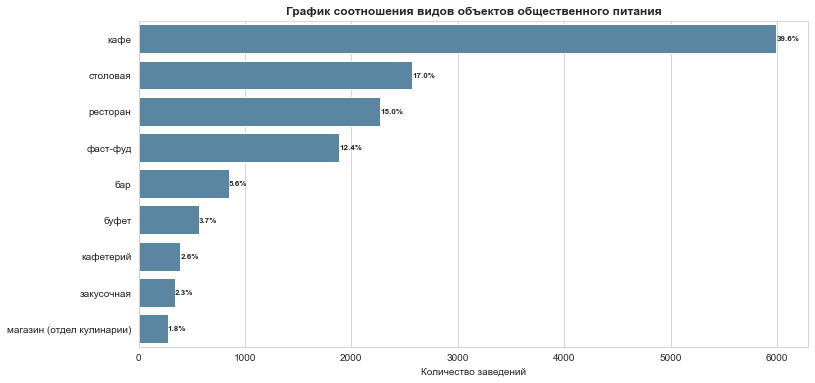

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x='count_object',y='object_type',data=places,color='#4e89ae')

for y,x in enumerate(places.count_object):
    ax.text(x,y,'{:.1%}'.format(x / places.count_object.sum()),va='center',fontweight='bold',fontsize=8)  
    
ax.set(ylabel=None)
ax.set_xlabel('Количество заведений',fontsize=10)
ax.set_title('График соотношения видов объектов общественного питания',fontweight='bold',fontsize=12)
plt.show()

**Кафе** имеет **39.6%** от общего количества заведений в выборке, следом идут **столовые** c **17%**, что в два раза меньше чем **кафе**.  

Топ-4 заведения это **кафе**, **столовые**, **рестораны** и **фаст-фуд**.

#### 2.2 Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

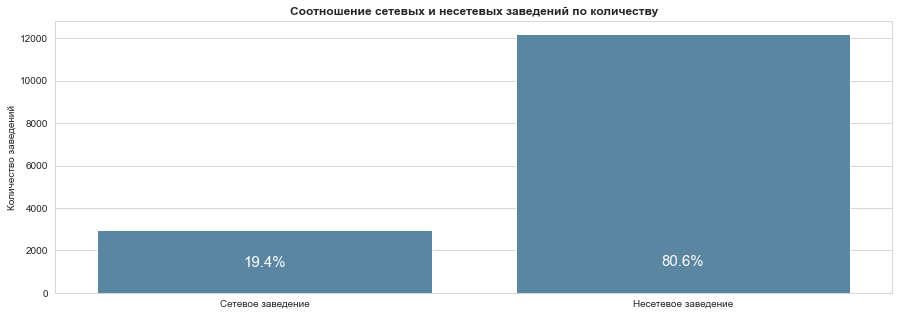

In [9]:
chain_table = (
    df
    .groupby('chain')
    .agg({'chain':'count'})
    .rename(columns={'chain':'count_chain'})
)
chain_table['count_chain_percent'] = (100 * chain_table.count_chain / chain_table.count_chain.sum()).round(1)
chain_table = chain_table.sort_values(by='count_chain_percent')

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    y=chain_table.count_chain,x=chain_table.count_chain_percent,color='#4e89ae')
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: '{} заведение'.format('Сетевое' if x == 0 else 'Несетевое')))

for x, y in enumerate(chain_table.count_chain_percent):
    ax.text(x, y + 1200, '{}%'.format(y) , horizontalalignment='center', fontsize=15,color='w')
    
ax.set_title('Cоотношение сетевых и несетевых заведений по количеству',fontweight='bold',fontsize=12)
ax.set_ylabel('Количество заведений',fontsize=10)
ax.set(xlabel=None)
plt.show()

Несетевых заведений гораздо больше.

#### 2.3 Для какого вида объекта общественного питания характерно сетевое распространение?


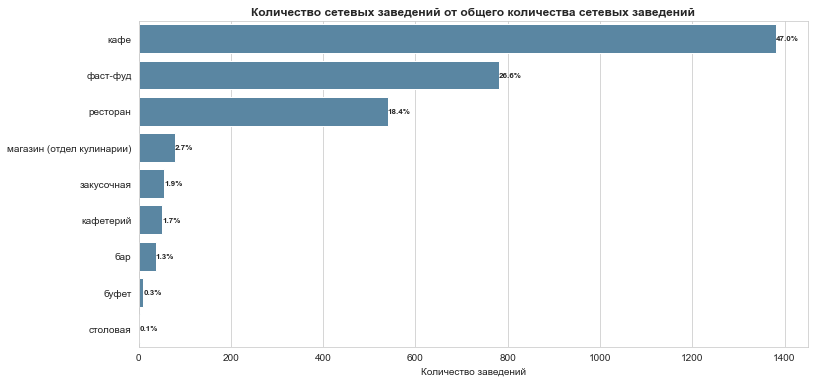

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
chain_sort = places.sort_values(by='chain_count',ascending=False)
sns.barplot(
    x='chain_count',y='object_type',data=chain_sort,color='#4e89ae')
for y,x in enumerate(chain_sort.chain_count):
    ax.text(x,y,'{:.1%}'.format(x / chain_sort.chain_count.sum()),va='center',fontweight='bold',fontsize=8)  
ax.set(ylabel=None)
ax.set_xlabel('Количество заведений',fontsize=10)
ax.set_title('Количество сетевых заведений от общего количества сетевых заведений',fontweight='bold',fontsize=12)
plt.show()

Наибольшее количество сетевых заведений у **кафе**.

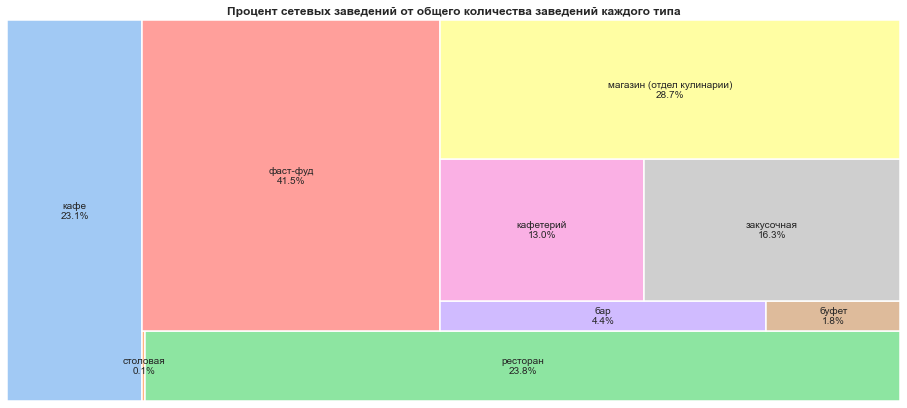

In [11]:
fig, ax = plt.subplots(figsize=(16, 7))
labels = places.apply(lambda x:str(x[0])+'\n'+str(x[5])+'%',axis=1)
sq.plot(sizes=places.chain_of_count_object_percent,label=labels,linewidth=1.5,edgecolor='w',
        color=sns.color_palette("pastel"))
ax.set_title('Процент сетевых заведений от общего количества заведений каждого типа',
             fontweight='bold',fontsize=12)
plt.axis('off')
plt.show()

Наибольшая доля сетевых заведения от общего числа заведений каждого типа у заведений типа **фаст-фуд**. Для данного типа наиболее характерно сетевое распространение.

#### 2.4 Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

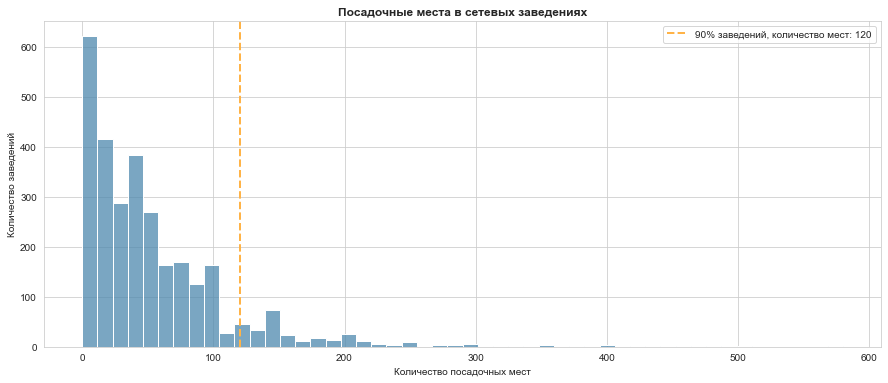

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(data=df.query('chain == 1')['number'],color='#4e89ae',bins=50)
ax.axvline(x=np.percentile(
    df.query('chain == 1')['number'],[90]),color='#ffb347',linestyle='--',linewidth=2,
           label='90% заведений, количество мест: {}'
           .format(np.percentile(df.query('chain == 1')['number'],[90][0]).astype(int))
)
ax.legend()
ax.set_ylabel('Количество заведений',fontsize=10)
ax.set_xlabel('Количество посадочных мест',fontsize=10)
ax.set_title('Посадочные места в сетевых заведениях',fontweight='bold',fontsize=12)
plt.show()

Для сетевых заведений характерно много заведений с небольшим числом посадочных мест, 90% всех заведений имеют до 120 посадочных мест.

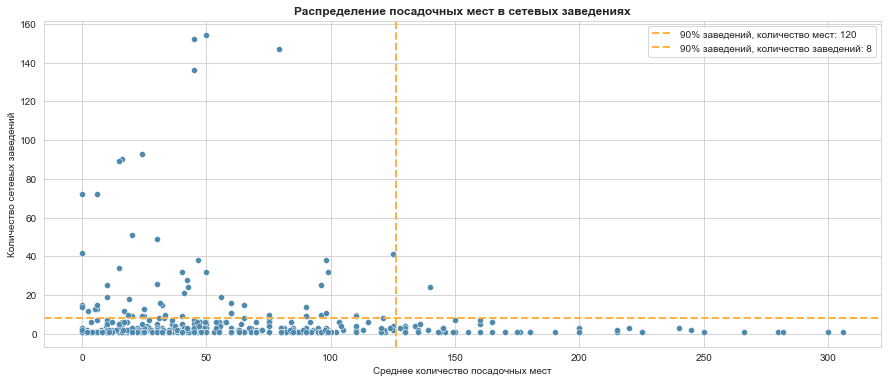

In [13]:
sc_c_n = (
    df
    .query('chain == 1')
    .groupby('object_name',as_index=False)
    .agg({'object_name': 'count','number':'median'})
)
fig, ax = plt.subplots(figsize=(15, 6))
ax.axvline(
    x=np.percentile(sc_c_n.number,[90]),color='#ffb347',linestyle='--',linewidth=2,
    label='90% заведений, количество мест: {}'
    .format(np.percentile(df.query('chain == 1')['number'],[90][0]).astype(int))
)
ax.axhline(
    y=np.percentile(sc_c_n.object_name,[90]),color='#ffb347',linestyle='--',linewidth=2,
    label='90% заведений, количество заведений: {}'
    .format(np.percentile(sc_c_n.object_name,[90][0]).astype(int))
)

sns.scatterplot(data=sc_c_n,y=sc_c_n.object_name,x=sc_c_n.number,color='#4e89ae')
ax.set_ylabel('Количество сетевых заведений',fontsize=10)
ax.set_xlabel('Среднее количество посадочных мест',fontsize=10)
ax.set_title('Распределение посадочных мест в сетевых заведениях',fontweight='bold',fontsize=12)
plt.show()

90% сетевых заведений имеют не больше 120 посадочных мест, 90% заведений в количестве не больше 8.

#### 2.5 Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

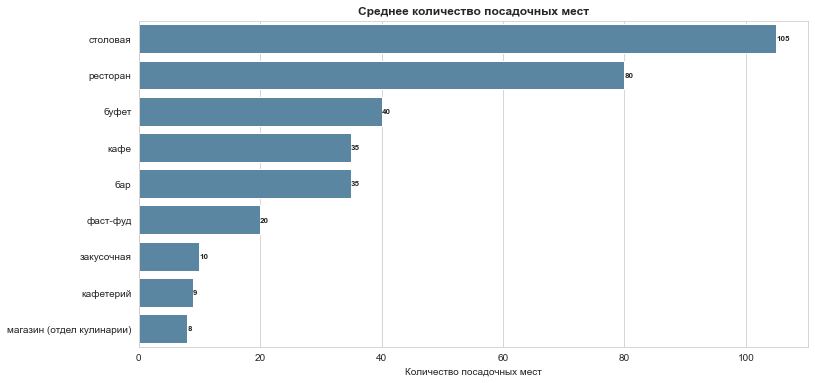

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
number_sort = places.sort_values(by='number_mean',ascending=False)
sns.barplot(x='number_mean',y='object_type',data=number_sort,color='#4e89ae')

for y,x in enumerate(number_sort.number_mean):
    ax.text(x,y,'{}'.format(x),va='center',fontweight='bold',fontsize=8)
    
ax.set(ylabel=None)
ax.set_xlabel('Количество посадочных мест',fontsize=10)
ax.set_title('Среднее количество посадочных мест',fontweight='bold',fontsize=12)
plt.show()

В среднем наибольшее количество посадочных мест в **столовой** (104), у **ресторанов** (80) и в **буфетах** (40). 

#### 2.6 Выделите в отдельный столбец информацию об улице из столбца address .

Сделаем запросы к Яндекс картам, чтобы получить координаты:

In [19]:
API_URL = 'https://geocode-maps.yandex.ru/1.x'

In [20]:
config = load(open('config.yaml'), Loader=FullLoader)
token = config['yandex maps']['token']

In [21]:
address_c = df.groupby('address',as_index=False)['id'].count().sort_values(by='id',ascending=False)
display(address_c.head(10))
print('Количество адресов: {}'.format(address_c.address.count()))

In [22]:
# цикл запросов
data = []
for address in address_c['address']:
    def make_request(address):
        params = {
            'geocode': address,
            'format': 'json',
            'apikey': token
        }
        response = requests.get(API_URL, params=params)
        return response.json()
    
    for n in range(3):
        try:
            data.append(make_request(address))
            break
        except:
            print('Запрос не удался, ожидание: {}'.format(2**(n+1)))
            time.sleep(2**(n+1))

In [23]:
street_name = []
object_address = []
coor = []

for i,address in enumerate(address_c.address[:10]):
    object_address.append(
        data[i]['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['name']
    )
    coor.append(
        data[i]['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
    )
    street_name.append(
        data[i]['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']\
        ['metaDataProperty']['GeocoderMetaData']['Address']['Components'][4]['name']
    )
sc = pd.DataFrame({
    'object_address': object_address,
    'street_name': street_name,
    'coordinates': coor
})

In [24]:
#sc.to_csv('Downloads/df_coor_rest.csv', sep='\t', index=False)
#sc2.to_csv('Downloads/df_coor_rest2.csv', sep='\t', index=False)

In [15]:
spreadsheets = {
    'file1': '1ERYhs63DU4qY_DMZMMCjzQB1-RaQ2dt4epaxK9wqNoU',
    'file2': '1g5hA64zr9oFS9xmoQERR9JvynVbfevF83K27KSel_cw',
    'file3': '1l8JDtd6ILV6Q2bOcoR-lkj1YdFOaalYc37b0RetwTeY',
    'file4': '1cy6Vpus2Xs4JL-aA60RF_apupvx4lwAozHaheo-C6mw',
}

coor_df = extract(spreadsheets['file1'])
coor_df2 = extract(spreadsheets['file2'])
coor_df3 = extract(spreadsheets['file3'])
coor_df4 = extract(spreadsheets['file4'])

In [16]:
coor_df = pd.merge(coor_df,coor_df2,how='outer').drop_duplicates()

Разобьем адрес на компоненты: 

In [17]:
address_re = df['address'].str.split(',', expand=True)
address_re.columns=['city','street','build', 'v1', 'v2', 'v3', 'v4']
address_re

city                   street            build              v1  \
0      город Москва    улица Егора Абакумова            дом 9            None   
1      город Москва         улица Талалихина          дом 2/1        корпус 1   
2      город Москва     Абельмановская улица            дом 6            None   
3      город Москва       Абрамцевская улица            дом 1            None   
4      город Москва       Абрамцевская улица            дом 9        корпус 1   
...             ...                      ...              ...             ...   
15359  город Москва     Кантемировская улица           дом 47            None   
15360  город Москва           улица Вавилова            дом 3            None   
15361  город Москва   3-й Крутицкий переулок           дом 18            None   
15363  город Москва       улица Земляной Вал           дом 33            None   
15364  город Москва     поселение Московский   Киевское шоссе   22-й километр   

                    v2           v3    v4  
0                 None         None  None  
1                 None         None  None  
2                 None         None  None  
3                 None         None  None  
4                 None         None  None  
...                ...          ...   ...  
15359             None         None  None  
15360             None         None  None  
15361             None         None  None  
15363             None         None  None  
15364   домовладение 4   строение 1  None  

[15141 rows x 7 columns]

In [18]:
address_re[address_re.city != 'город Москва']

city            street        build    v1    v2  \
859             Партизанская улица            дом 30         None  None  None   
860             Партизанская улица            дом 30         None  None  None   
1491                Поречная улица          дом 5/14   строение 1  None  None   
7691        1-й Нагатинский проезд            дом 10         None  None  None   
7827          Софийская набережная          дом 26/1   строение 1  None  None   
...                            ...               ...          ...   ...   ...   
13185             Бауманская улица             дом 7   строение 3  None  None   
13399              Солянский тупик           дом 1/4   строение 1  None  None   
13991            Таганская площадь            дом 88   строение 4  None  None   
14003  Шарикоподшипниковская улица             дом 5   строение 1  None  None   
15015       поселение "Мосрентген"   деревня Дудкино   владение 1  None  None   

         v3    v4  
859    None  None  
860    None  None  
1491   None  None  
7691   None  None  
7827   None  None  
...     ...   ...  
13185  None  None  
13399  None  None  
13991  None  None  
14003  None  None  
15015  None  None  

[71 rows x 7 columns]

71 адрес в параметре **city** имеют улицу, исправим это:

In [19]:
address_re.loc[address_re['city'] != 'город Москва','v1'] = (
    address_re.loc[address_re['city'] != 'город Москва']['build']
)
address_re.loc[address_re['city'] != 'город Москва','build'] = (
    address_re.loc[address_re['city'] != 'город Москва']['street']
)
address_re.loc[address_re['city'] != 'город Москва','street'] = (
    address_re[address_re['city'] != 'город Москва']['city']
)

# аналогичная замена
address_re.loc[address_re['build'] == ' Киевское шоссе','v1'] = (
    address_re.loc[address_re['build'] == ' Киевское шоссе']['v3']
)
address_re.loc[address_re['build'] == ' Киевское шоссе','build'] = (
    address_re.loc[address_re['build'] == ' Киевское шоссе']['v2']
)

list_w = [
    'улица','деревня','посёлок','площадь','село',
    'аллея','проспект','проезд','микрорайон','бульвар',
    'Олимпийская Деревня'
]

for w in list_w:
    address_re.loc[address_re['build'].str.contains(w),'street'] = (
        address_re.loc[address_re['build'].str.contains(w),'street'] + ', ' + address_re.loc[address_re['build'].str.contains(w)]['build'])
    address_re.loc[address_re['build'].str.contains(w),'build'] = (
        address_re.loc[address_re['build'].str.contains(w)]['v1'])

In [20]:
address_re.loc[address_re['build'].str.contains('улица'),'street'] = (
    address_re.loc[address_re['build'].str.contains('улица'),'street'] + ', ' + address_re.loc[address_re['build'].str.contains('улица')]['build'])
address_re.loc[address_re['build'].str.contains('улица'),'build'] = (
    address_re.loc[address_re['build'].str.contains('улица')]['v2'])

In [21]:
# замена
address_re['street'] = address_re['street'].str.replace('город ', '')

address_re['build'] = (
    address_re['build']
    .str.replace('дом ', '')
    .str.replace('домовладение ', '')
    .str.replace('владение ', '')
    .str.replace('корпус ', 'к'))

address_re['v1'] = (
    address_re['v1']
    .str.replace('корпус ', 'к')
    .str.replace('строение ', 'с'))

# слияние build,v1
address_re.loc[address_re['v1'].notna(),'build'] = (
    address_re.loc[address_re['v1'].notna(),'build'] + address_re.loc[address_re['v1'].notna()]['v1'])
address_re['build'] = address_re['build'].str.replace(' ','')

In [22]:
# разбивка
address_coor = coor_df['object_address'].str.split(',', expand=True)
address_coor.columns=['street','build', 'v1','v2']

address_coor = address_coor.join(coor_df['coordinates'])
# пробелы
address_re['street'] = address_re.street.str.lstrip()
address_re['build'] = address_re.build.str.lstrip()
address_coor['street'] = address_coor.street.str.lstrip()
address_coor['build'] = address_coor.build.str.lstrip() 
del address_coor['v1']
del address_coor['v2']

df = df.join(address_re[['street','build']])
df = pd.merge(df, address_coor, how = 'left', left_on=['street','build'], right_on=['street','build'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15143 entries, 0 to 15142
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15143 non-null  int64 
 1   object_name  15143 non-null  object
 2   chain        15143 non-null  int64 
 3   object_type  15143 non-null  object
 4   address      15143 non-null  object
 5   number       15143 non-null  int64 
 6   street       15143 non-null  object
 7   build        15143 non-null  object
 8   coordinates  13592 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.2+ MB


Для определения района нужно делать повторные запросы по координатам.  
**10.2%** пропусков из-за сложности обработки адреса и ограничению количества запросов к Яндекс картам в сутки.  
В столбце **street** 2013 улиц.

Среди данных есть много чего еще, но заниматься их "чисткой" в данном проекте такой задачи нет.

#### 2.7 Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

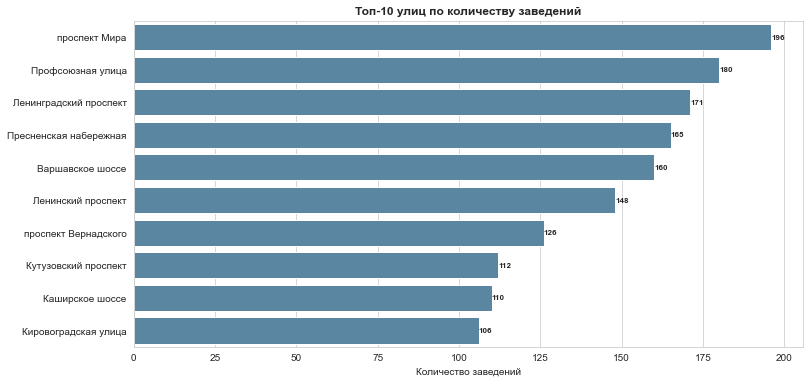

In [26]:
top_street = (
    df
    .groupby('street',as_index=False)
    .agg({'id':'count'})
    .rename(columns={'id':'rest_count'})
    .sort_values(by='rest_count',ascending=False)
)
top_street = top_street.query('street !="Зеленоград"')[:10]

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_count',y='street',data=top_street,color='#4e89ae')

for y,x in enumerate(top_street.rest_count):
    ax.text(x,y,x,va='center',fontweight='bold',fontsize=8)    
ax.set(ylabel=None)
ax.set_xlabel('Количество заведений',fontsize=10)
ax.set_title('Топ-10 улиц по количеству заведений',fontweight='bold',fontsize=12)
plt.show()  

По количеству заведений лидирует улица **проспект Мира**.

In [27]:
cr = df['coordinates'].str.split(' ', expand=True)
cr.columns = ['lon','lat']
df = df.join(cr)

df['lon'] = df['lon'].astype(float)
df['lat'] = df['lat'].astype(float)

In [28]:
# фрейм с районами
coor_df3 = coor_df3.merge(coor_df4,how='outer')
df = pd.merge(df, coor_df3, how='left', left_on='coordinates', right_on='pos')

In [29]:
del df['pos']

In [30]:
# данные для топ 10

top_frame = pd.DataFrame()

for i,adreess in enumerate(top_street.street.unique()):
    h = top_street.street.unique()[i]
    f = df.query('street == @h')[['object_name','street','lat','lon','district_r_name']]
    top_frame = pd.concat([top_frame,f])

Метки на карте с заведениями для топ-10 улиц:

In [32]:
fig = px.scatter_mapbox(
    top_frame,lat=top_frame['lat'],lon=top_frame['lon'],
    text=top_frame['district_r_name'],color=top_frame['street'],
    title= 'Распределение заведений по улицам из топ-10')

map_center = go.layout.mapbox.Center(lat=df['lat'].values[8327],lon=df['lon'].values[8327])
fig.update_layout(
    legend_title_text='Улица:',mapbox_style="open-street-map",
    mapbox=dict(center=map_center,zoom=8.3))
fig.show()

In [33]:
n = [
    'Центральный административный округ','Северный административный округ',
    'Западный административный округ','Северный административный округ',
    'Северо-Западный административный округ','Восточный административный округ',
    'Юго-Западный административный округ','Южный административный округ',
    'Юго-Восточный административный округ','Северо-Восточный административный округ',
]

In [35]:
fig = px.scatter_mapbox(
    df[df.query('district_name == @n').notna()].dropna(),
    lat=df[df.query('district_name == @n').notna()].dropna()['lat'],
    lon=df[df.query('district_name == @n').notna()].dropna()['lon'],
    text=df[df.query('district_name == @n').notna()].dropna()['object_name'],
    color=df[df.query('district_name == @n').notna()].dropna()['district_name'],
    title= 'Заведения по округам')

map_center = go.layout.mapbox.Center(lat=df['lat'].values[8327],lon=df['lon'].values[8327])
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(center=map_center,zoom=8))
fig.show()

In [36]:
fig = px.scatter_mapbox(
    df[df['district_r_name'].notna()],
    lat=df[df['district_r_name'].notna()]['lat'],
    lon=df[df['district_r_name'].notna()]['lon'],
    text=df[df['district_r_name'].notna()]['district_r_name'],
    color=df[df['district_r_name'].notna()]['district_r_name'],
    title= 'Заведения по районам'
)
map_center = go.layout.mapbox.Center(lat=df['lat'].values[8327],lon=df['lon'].values[8327])
fig.update_layout(showlegend=False,mapbox_style="open-street-map",mapbox=dict(center=map_center,zoom=8))
fig.show()

Районы заведений из топ-10:

In [38]:
st_t = list(top_street.street)

top_street_2 = (
    df
    .groupby(['street','district_r_name','chain','object_type'],as_index=False)
    .agg({'id':'count'})
    .sort_values(by='id',ascending=False)
)
top_street_2 = top_street_2.query('district_r_name != "Россия"')

In [51]:
tb = (
    top_street_2
    .query('street == @st_t')
    .groupby(['street','district_r_name'])
    .agg({'id':'nunique','object_type':['min','max'],'chain':'min'})
    .rename(columns={'id':'r_count'}))
tb

r_count object_type  \
                                                       nunique         min   
street                 district_r_name                                       
Варшавское шоссе       Донской район                         4       буфет   
                       Нагорный район                        2        кафе   
                       район Нагатино-Садовники              1    фаст-фуд   
                       район Чертаново Северное              4         бар   
                       район Чертаново Центральное           3        кафе   
                       район Чертаново Южное                 5         бар   
                       район Южное Бутово                    1   кафетерий   
Каширское шоссе        район Москворечье-Сабурово            6       буфет   
                       район Нагатино-Садовники              5         бар   
                       район Орехово-Борисово Северное       2        кафе   
                       район Орехово-Борисово Южное          2        кафе   
Кировоградская улица   район Чертаново Северное              2         бар   
                       район Чертаново Центральное           8         бар   
                       район Чертаново Южное                 2        кафе   
Кутузовский проспект   район Дорогомилово                    4         бар   
                       район Фили-Давыдково                  6         бар   
Ленинградский проспект Хорошёвский район                     3        кафе   
                       район Аэропорт                        6         бар   
                       район Беговой                         5         бар   
                       район Сокол                           2        кафе   
Ленинский проспект     Гагаринский район                     3        кафе   
                       Донской район                         2         бар   
                       Ломоносовский район                   1        кафе   
                       Обручевский район                     4         бар   
                       район Коньково                        1        кафе   
                       район Проспект Вернадского            1        кафе   
                       район Тропарёво-Никулино              3        кафе   
                       район Тёплый Стан                     1        кафе   
                       район Якиманка                        2         бар   
Пресненская набережная Пресненский район                     7         бар   
Профсоюзная улица      Академический район                   1        кафе   
                       Обручевский район                     6        кафе   
                       район Коньково                        5         бар   
                       район Тёплый Стан                     4        кафе   
                       район Черёмушки                       5         бар   
                       район Ясенево                         3        кафе   
проспект Вернадского   Ломоносовский район                   1        кафе   
                       район Проспект Вернадского            3        кафе   
                       район Раменки                         3        кафе   
                       район Тропарёво-Никулино              6         бар   
проспект Мира          Алексеевский район                    2        кафе   
                       Мещанский район                       5         бар   
                       Останкинский район                    1  закусочная   
                       Ярославский район                     1   кафетерий   
                       район Ростокино                       2         бар   
                       район Свиблово                        6         бар   

                                                                  chain  
                                                              max   min  
street                 district_r_name                                   
Варшавское

#### 2.8 Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [48]:
str_rest = (
    df
    .groupby(['street','district_r_name'],as_index=False)
    .agg({'id':'count','object_name':'min','object_type':'min','lon':'max','lat':'min'})
    .rename(columns={'id':'rest_count'})
)
one_rest_street = str_rest.query('rest_count == 1')

In [49]:
print(
    'Число улиц с одним объектом общественного питания : {}'
    .format(one_rest_street['street'].count())
)

Число улиц с одним объектом общественного питания : 872


In [50]:
fig = px.scatter_mapbox(
    one_rest_street,lat=one_rest_street['lat'],lon=one_rest_street['lon'],
    text=one_rest_street['district_r_name'],color=one_rest_street['district_r_name'],
    title= 'Заведения с одним объектом общественного питания на улице'
)
map_center = go.layout.mapbox.Center(lat=df['lat'].values[8327],lon=df['lon'].values[8327])
fig.update_layout(showlegend=False,mapbox_style="open-street-map",mapbox=dict(center=map_center,zoom=8))
fig.show()

#### Вывод:

* Самый популярный тип заведений - кафе, столовая, ресторан, фастфуд
* 80 % заведений несетевые
* в среднем больше всего посадочных мест в столовых
* самые насыщенные заведениями улицы: Варшавское шоссе, Каширское шоссе, Кировоградская улица, Кутузовский проспект, Ленинградский проспект, Ленинский проспект, Пресненская набережная, Профсоюзная улица, проспект Вернадского, проспект Мира
* количество единственных заведений на одну улицу около 800
* в ЦАО наибольшее количество заведений

В Москве еще достаточно улиц с одним заведением, заведений типа **кафе** очень много.

Рекомендации:  
Можно присмотреться к центральным районам раз проект дорогой, отобрать те районы где конкуренция минимальна и кафе с роботами будет наиболее "уместно", например студ. район рядом с вузом, бизнес-центры и т.п., изучить транспорт, проходимость, портрет клиента в данном районе.
Все кафе имеют среднее количество посадочных мест - 35, от этого количества и отталкиваться.